#  <center> Classify Art Images into categories using a CNN<br> 
## The art categories are the following:
- Drawings
- Engraving
- Iconography
- Painting
- Sculpture

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

# Display progress
from ipywidgets import IntProgress
from IPython.display import display
from livelossplot import PlotLossesKeras

# data processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Graphs
import matplotlib.pyplot as plt

# Image
import skimage.io
import skimage.transform

# Deep learning
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### Import Dataset

In [3]:
training_data_path = "dataset" + os.path.sep + "training_set" + os.path.sep
test_data_path = "dataset" + os.path.sep + "validation_set" + os.path.sep
print(training_data_path)
print(test_data_path)

dataset\training_set\
dataset\validation_set\


### Define the classes

In [4]:
classes = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
n_classes = len(classes)

### Embedding

In [5]:
classes_embeddings = {
    'drawings': 0,
    'engraving': 1,
    'iconography': 2,
    'painting': 3,
    'sculpture': 4
}

### Read class path

In [6]:
training_data_paths = []
for class_name in classes:
    class_path = training_data_path + class_name + os.path.sep
    training_data_paths.append(class_path)
print(training_data_paths)

test_data_paths = []
for class_name in classes:
    class_path = test_data_path + class_name + os.path.sep
    test_data_paths.append(class_path)
print(test_data_paths)

['dataset\\training_set\\drawings\\', 'dataset\\training_set\\engraving\\', 'dataset\\training_set\\iconography\\', 'dataset\\training_set\\painting\\', 'dataset\\training_set\\sculpture\\']
['dataset\\validation_set\\drawings\\', 'dataset\\validation_set\\engraving\\', 'dataset\\validation_set\\iconography\\', 'dataset\\validation_set\\painting\\', 'dataset\\validation_set\\sculpture\\']


### Delete images that can't be opened

In [7]:
# Training data
for cidx, data_path in enumerate(training_data_paths):
    files = os.listdir(data_path)
    print(cidx)
    print(classes[cidx])
    print("Nr.Files:", len(files))
    for file in files:
        img_name = data_path+file
        try:
            img = cv2.imread(img_name)
            img = skimage.transform.resize(img, (128,128,3), mode='reflect')
        except:
            print("Exception when opening file:", img_name)
            print("Delete this file")
            os.remove(img_name)

0
drawings
Nr.Files: 1107
1
engraving
Nr.Files: 760
Exception when opening file: dataset\training_set\engraving\249.jpg
Delete this file
Exception when opening file: dataset\training_set\engraving\304.jpg
Delete this file
Exception when opening file: dataset\training_set\engraving\356.jpg
Delete this file
2
iconography
Nr.Files: 2079
Exception when opening file: dataset\training_set\iconography\331.jpg
Delete this file
Exception when opening file: dataset\training_set\iconography\69.jpg
Delete this file
3
painting
Nr.Files: 2128
Exception when opening file: dataset\training_set\painting\0000.jpg
Delete this file
Exception when opening file: dataset\training_set\painting\0025.jpg
Delete this file
Exception when opening file: dataset\training_set\painting\0050.jpg
Delete this file
Exception when opening file: dataset\training_set\painting\0075.jpg
Delete this file
Exception when opening file: dataset\training_set\painting\0125.jpg
Delete this file
Exception when opening file: dataset\tra

In [8]:
# Test data
for cidx, data_path in enumerate(test_data_paths):
    files = os.listdir(data_path)
    print(cidx)
    print(classes[cidx])
    print("Nr.Files:", len(files))
    for file in files:
        img_name = data_path+file
        try:
            img = cv2.imread(img_name)
            img = skimage.transform.resize(img, (128,128,3), mode='reflect')
        except:
            print("Exception when opening file:", img_name)
            print("Delete this file")
            os.remove(img_name)

0
drawings
Nr.Files: 122
1
engraving
Nr.Files: 84
2
iconography
Nr.Files: 231
3
painting
Nr.Files: 236
Exception when opening file: dataset\validation_set\painting\0300.jpg
Delete this file
Exception when opening file: dataset\validation_set\painting\1150.jpg
Delete this file
Exception when opening file: dataset\validation_set\painting\1250.jpg
Delete this file
Exception when opening file: dataset\validation_set\painting\1550.jpg
Delete this file
Exception when opening file: dataset\validation_set\painting\1600.jpg
Delete this file
Exception when opening file: dataset\validation_set\painting\2200.jpg
Delete this file
Exception when opening file: dataset\validation_set\painting\2225.jpg
Delete this file
Exception when opening file: dataset\validation_set\painting\2275.jpg
Delete this file
4
sculpture
Nr.Files: 193
Exception when opening file: dataset\validation_set\sculpture\106.jpg
Delete this file
Exception when opening file: dataset\validation_set\sculpture\170.jpg
Delete this file


### Plotting

[1107, 757, 2077, 2042, 1738]
[122, 84, 231, 228, 191]


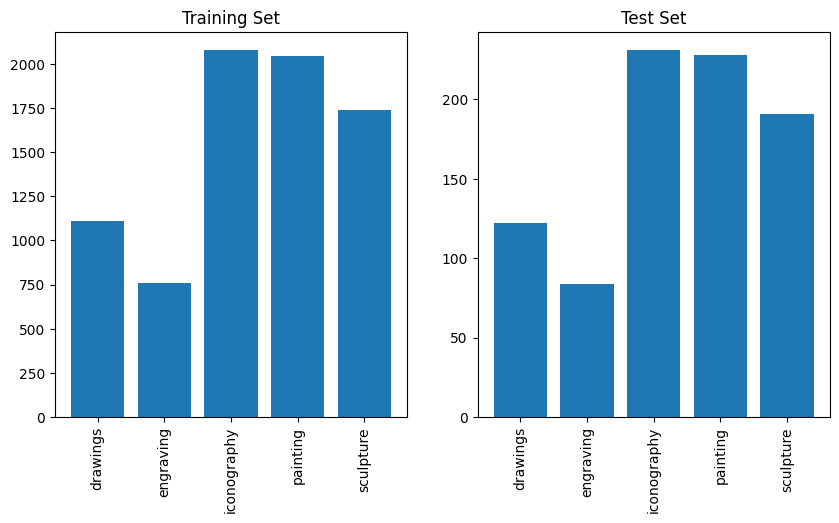

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) 
images_count_per_class = []
for data_path in training_data_paths:
    files = os.listdir(data_path)
    images_count_per_class.append(len(files))
print(images_count_per_class)

axs[0].bar([*range(n_classes)], images_count_per_class, tick_label=classes)
axs[0].set_xticklabels(classes, rotation = 90)
axs[0].set_title("Training Set")

images_count_per_class = []
for data_path in test_data_paths:
    files = os.listdir(data_path)
    images_count_per_class.append(len(files))
print(images_count_per_class)
axs[1].bar([*range(n_classes)], images_count_per_class, tick_label=classes)
axs[1].set_xticklabels(classes, rotation = 90)
axs[1].set_title("Test Set")

plt.show()

### Visualize a sample image from each class.

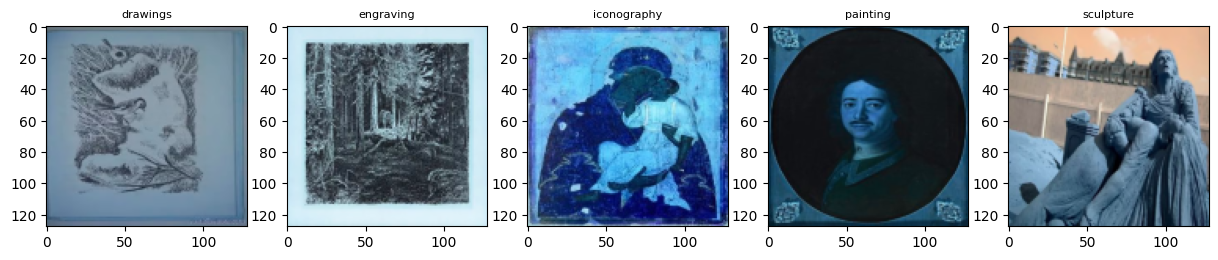

In [10]:
#set figure size
fig, axs = plt.subplots(nrows=1, ncols=n_classes, figsize=(15, 3))    
for cidx, data_path in enumerate(training_data_paths):
    files = os.listdir(data_path)
    rand_file_sel = np.random.randint(0, len(files), 1, dtype=int)
    fidx = rand_file_sel[0]

    img_name = data_path+files[fidx]
    img = cv2.imread(img_name)
    img = skimage.transform.resize(img, (128,128,3), mode='reflect') #128, 128, 3 are the width,height and number of channels in the image
    axs[cidx].imshow(img, resample=True)
    axs[cidx].set_title(classes[cidx], fontsize=8)

### Create training and test sets

In [11]:
num_training_samples = 0
for cidx, data_path in enumerate(training_data_paths):
    files = os.listdir(data_path)
    num_training_samples += len(files)

num_test_samples = 0
for cidx, data_path in enumerate(test_data_paths):
    files = os.listdir(data_path)
    num_test_samples += len(files)

In [12]:
# Training set
f = IntProgress(min=0, max=num_training_samples) # instantiate the bar
display(f) # display the bar

X_train = []
y_train = []
for cidx, data_path in enumerate(training_data_paths):
    class_name = classes[cidx]
    class_label = classes_embeddings[class_name]
    files = os.listdir(data_path)
    for img_file in files:
        img = cv2.imread(data_path+img_file)
        img = skimage.transform.resize(img, (128,128,3), mode='reflect') #128, 128, 3 are the width,height and number of channels in the image
        X_train.append(img)
        y_train.append(class_label)
        f.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=7721)

In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [14]:
# Test set
f = IntProgress(min=0, max=num_test_samples) # instantiate the bar
display(f) # display the bar

X_test = []
y_test = []
for cidx, data_path in enumerate(test_data_paths):
    class_name = classes[cidx]
    class_label = classes_embeddings[class_name]
    files = os.listdir(data_path)
    for img_file in files:
        img = cv2.imread(data_path+img_file)
        img = skimage.transform.resize(img, (128,128,3), mode='reflect') #128, 128, 3 are the width,height and number of channels in the image
        X_test.append(img)
        y_test.append(class_label)
        f.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=856)

In [15]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(856, 128, 128, 3)
(856,)


### Data Augmentation

Stratified sampling explained:

https://stackoverflow.com/questions/53842547/number-of-training-samples-for-each-class-using-imagedatagenerator-with-validati

In [16]:
val_split = 0.25
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, stratify=y_train)
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

### Data augmentation parameters explained:
https://medium.com/analytics-vidhya/understanding-image-augmentation-using-keras-tensorflow-a6341669d9ca

In [17]:
# train_datagen = ImageDataGenerator(
#     rotation_range=45,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     brightness_range=[0.2, 0.8],
#     shear_range=20,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=False,
#     validation_split=val_split)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=val_split)

train_datagen.fit(X_train)

### Define CNN model architecture

In [18]:
reg_val = 1e-4
regularizer=regularizers.L2(reg_val)
model = Sequential()

#model.add(Conv2D(32, kernel_size=5, input_shape=(128,128,3), activation='relu'))
model.add(Conv2D(32, kernel_size=5, input_shape=(128,128,3), activation='relu', kernel_regularizer=regularizer, bias_regularizer=regularizer, activity_regularizer=regularizer))
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Conv2D(48, kernel_size=5, activation='relu'))
model.add(Conv2D(48, kernel_size=5, activation='relu', kernel_regularizer=regularizer, bias_regularizer=regularizer, activity_regularizer=regularizer))
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer=regularizer, bias_regularizer=regularizer, activity_regularizer=regularizer))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.L2(reg_val), bias_regularizer=regularizers.L2(reg_val)))

model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        27712     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)     

In [19]:
# reg_val = 1e-3
# model = Sequential()
# model.add(Conv2D(32, kernel_size=5, input_shape=(128,128,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(48, kernel_size=5, input_shape=(128,128,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.35))

# model.add(Flatten())
# model.add(Dense(256, activation='relu',
#                     kernel_regularizer=regularizers.L2(reg_val),
#                     bias_regularizer=regularizers.L2(reg_val)))
# model.add(Dropout(0.25))
# model.add(Dense(n_classes, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# reg_val = 1e-3
# model = Sequential()
# model.add(Conv2D(48, kernel_size=5, input_shape=(128,128,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.35))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(n_classes, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Fit the model

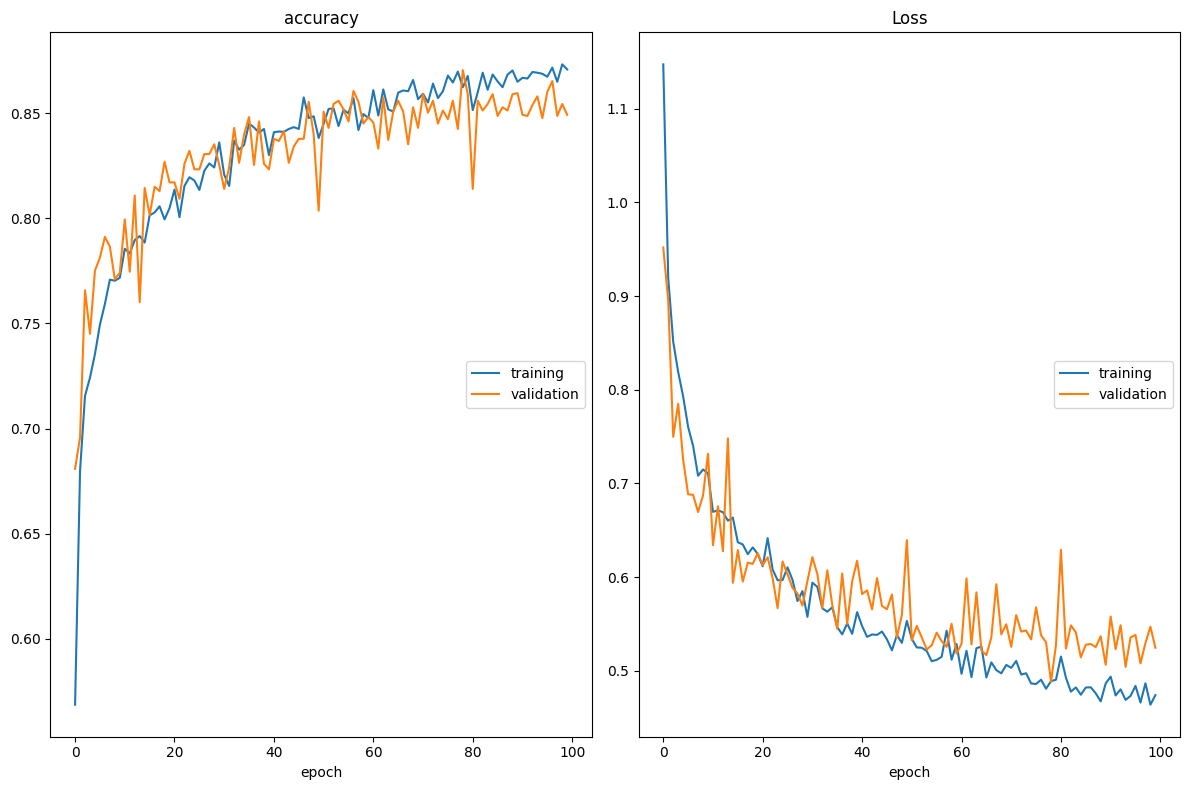

accuracy
	training         	 (min:    0.569, max:    0.873, cur:    0.871)
	validation       	 (min:    0.681, max:    0.870, cur:    0.849)
Loss
	training         	 (min:    0.464, max:    1.147, cur:    0.474)
	validation       	 (min:    0.488, max:    0.952, cur:    0.525)
181/181 [==============================] - 25s 139ms/step - loss: 0.4740 - accuracy: 0.8708 - val_loss: 0.5246 - val_accuracy: 0.8492


In [21]:
training_result = model.fit(train_datagen.flow(X_train, y_train, batch_size=32, subset='training',shuffle = True),
                            validation_data=train_datagen.flow(X_train, y_train, batch_size=8, subset='validation', shuffle = True),
                            batch_size=64,epochs=100, 
                            callbacks = [PlotLossesKeras()], verbose=1)

### Analyze model

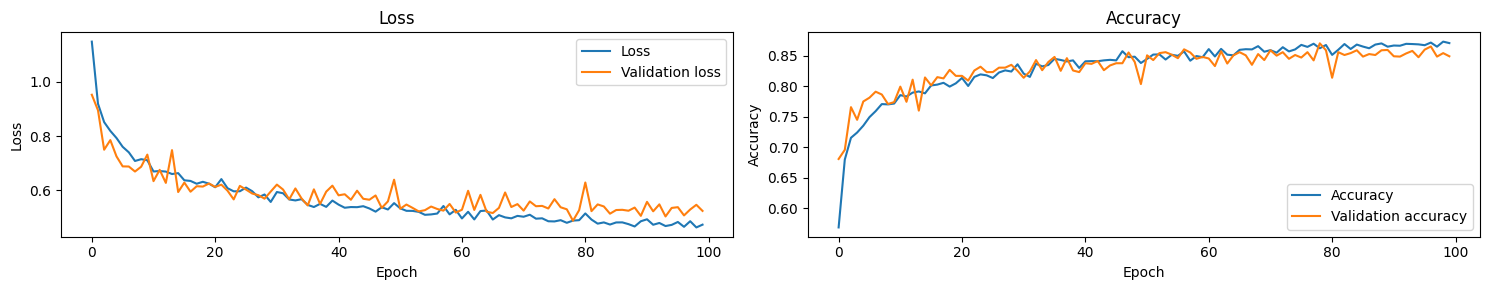

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(training_result.history['loss'], label="Loss")
axes[0].plot(training_result.history['val_loss'], label="Validation loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(training_result.history['accuracy'], label="Accuracy")
axes[1].plot(training_result.history['val_accuracy'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

### Classification Report

In [23]:
pred = model.predict(X_test, verbose=1)

y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

27/27 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.58      0.63      0.61       122
           1       0.84      0.45      0.59        84
           2       0.94      0.95      0.94       231
           3       0.96      0.91      0.93       228
           4       0.80      0.97      0.88       191

    accuracy                           0.85       856
   macro avg       0.83      0.78      0.79       856
weighted avg       0.85      0.85      0.84       856



### Confusion Matrix

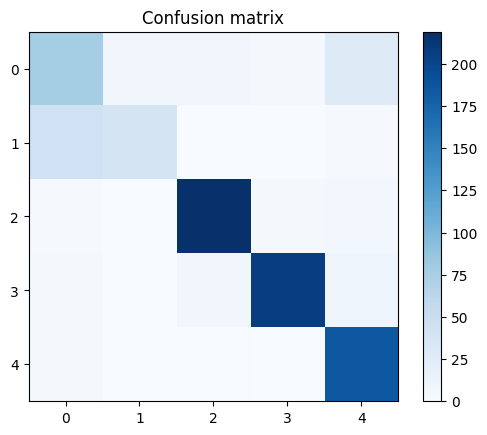

[[ 77   7   7   4  27]
 [ 44  38   0   0   2]
 [  2   0 219   4   6]
 [  4   0   7 207  10]
 [  5   0   1   0 185]]


In [24]:
c_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(c_matrix, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.show()
print(c_matrix)